In [1]:

import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow.keras
import numpy as np
import tensorflow as tf

tf.config.run_functions_eagerly(False)

2024-04-16 18:44:49.109021: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 18:44:49.159429: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 18:44:50.115612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BINARY_SIZE = 2
PATCH_SIZE = 8
BATCH_SIZE = 256

In [3]:
def load_keras_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 255.
    return x_train

def load_stl10():
    path = "data/stl10/train_X.bin"

    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(-1, 3, 96, 96)
        data = np.transpose(data, (0, 3, 2, 1))
        data = data.astype('float32') / 255.
    return data


def get_data():
    cifar10_dataset = load_keras_dataset('cifar10')
    cifar100_dataset = load_keras_dataset('cifar100')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)
    
    return dataset

def get_validation_data():
    cifar100_dataset = load_keras_dataset('cifar100')[:500]

    return cifar100_dataset

def get_simple_data():
    cifar10_dataset = load_keras_dataset('cifar10')

    return cifar10_dataset

In [4]:
dataset = get_simple_data()
val_dataset = get_validation_data()

In [5]:
dataset.shape

(60000, 32, 32, 3)

In [6]:
# dataset to ycbcr
dataset = tf.image.rgb_to_yuv(dataset)
val_dataset = tf.image.rgb_to_yuv(val_dataset)

2024-04-16 18:44:53.272586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 18:44:53.365458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 18:44:53.365558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 18:44:53.370116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 18:44:53.370241: I tensorflow/compile

In [9]:
# tf.compat.v1.disable_eager_execution()
image_input = tensorflow.keras.layers.Input(shape=(None, None, 3))
x = tensorflow.keras.layers.Conv2D(32, (3, 3), padding='same')(image_input)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
encoded = tensorflow.keras.layers.Dense(BINARY_SIZE, activation='relu')(x)

x = tensorflow.keras.layers.UpSampling2D((2, 2))(encoded)
x = tensorflow.keras.layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
decoded = tensorflow.keras.layers.Conv2DTranspose(3, (3, 3), padding='same', activation='tanh')(x)

autoencoder = tensorflow.keras.Model(image_input, decoded)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


autoencoder.fit(dataset, dataset, epochs=50, shuffle=True, batch_size=BATCH_SIZE, validation_data=(val_dataset, val_dataset))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 32)    896       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, None, None, 32)    0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, None, None, 64)    0         
                                                           

KeyboardInterrupt: 

In [ ]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [ ]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')

image_copy = image
image = tf.image.rgb_to_yuv(image)
image, h, w  = pad_image(image, 8)
image = tf.expand_dims(image, axis=0)

reconstructed_image_32 = autoencoder.predict(image)

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

reconstructed_image_32 = tf.image.yuv_to_rgb(reconstructed_image_32)
reconstructed_image_32 = tf.cast(reconstructed_image_32 * 255, tf.uint8)


1/1 [==============================] - 1s 855ms/step


In [ ]:
# get rid of first dimension
image = tf.squeeze(image)
reconstructed_image_32 = tf.squeeze(reconstructed_image_32)

In [ ]:
reconstructed_image_32 = reconstructed_image_32[:image_copy.shape[0], :image_copy.shape[1]]
image = image[:image_copy.shape[0], :image_copy.shape[1]]

print(image.shape)
print(reconstructed_image_32.shape)

(467, 396, 3)
(467, 396, 3)


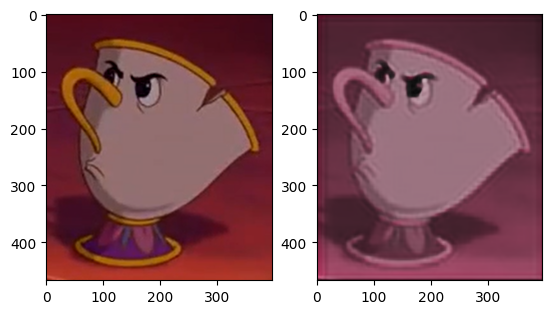

In [ ]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_32)

In [ ]:
# compute psnr
tf.image.psnr(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=20.589287>

In [ ]:
tf.image.ssim(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8158796>

In [ ]:
tf.image.ssim_multiscale(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.88679236>

In [ ]:
encoder = tensorflow.keras.Model(image_input, encoded)

In [ ]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')
image = tf.image.rgb_to_yuv(image)

image_, _, _ = pad_image(image, 8)

width = image_.shape[1]
height = image_.shape[0]

image_ = tf.expand_dims(image_, axis=0)

encoded_patches = encoder.predict(image_)

1/1 [==============================] - 0s 376ms/step


In [ ]:
encoded_patches = encoded_patches.astype(np.float16)
copy_encoded_patches = encoded_patches.copy()

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(None, None, BINARY_SIZE))
decoder = tensorflow.keras.Model(encoded, decoded)

rec = decoder.predict(encoded_patches)

1/1 [==============================] - 0s 78ms/step


In [ ]:
rec.shape

(1, 472, 400, 3)

In [ ]:
reconstructed_image_16 = tf.squeeze(rec)
reconstructed_image_16 = tf.image.yuv_to_rgb(reconstructed_image_16)

reconstructed_image_16 = reconstructed_image_16[:image.shape[0], :image.shape[1]]
reconstructed_image_16 = tf.convert_to_tensor(reconstructed_image_16)
reconstructed_image_16 = tf.cast(reconstructed_image_16 * 255, tf.uint8)

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

In [ ]:
print(image.shape)
print(reconstructed_image_16.shape)

(467, 396, 3)
(467, 396, 3)


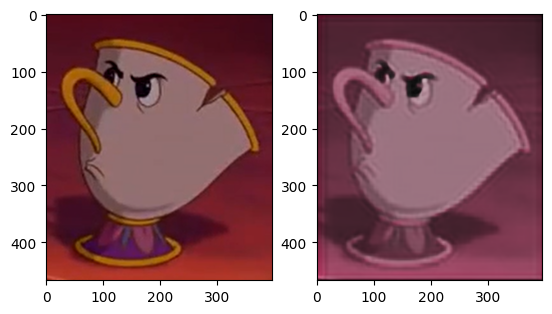

In [ ]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_16)

In [ ]:
tf.image.psnr(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=20.5892>

In [ ]:
tf.image.ssim(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8158738>

In [ ]:
tf.image.ssim_multiscale(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.886786>

In [ ]:
encoded_patches.shape

(1, 59, 50, 2)